# Vietnamese-English Neural Machine Translation with Transformer

## Project Overview

This notebook implements a **Vietnamese-English Machine Translation** system using the Transformer architecture from scratch.

### What We'll Cover:
1. **Data Loading & Exploration** - Load the VLSP parallel corpus
2. **Data Preprocessing** - Clean and filter sentence pairs  
3. **Tokenization** - Build BPE (Byte-Pair Encoding) tokenizers
4. **Dataset Preparation** - Create PyTorch datasets and dataloaders
5. **Model Architecture** - Implement Transformer from scratch
6. **Training** - Train with label smoothing and learning rate scheduling
7. **Evaluation** - Calculate BLEU scores
8. **Inference** - Translate new sentences with beam search

### Configuration
- **Dataset**: VLSP Vietnamese-English parallel corpus
- **Max Sequence Length**: 128 tokens
- **Model**: Transformer (6 layers, 8 heads, 512 dim)
- **Batch Size**: 64

---

## 1. Import Libraries and Configuration

Import all required libraries including:
- **PyTorch** for deep learning
- **Tokenizers** for BPE tokenization
- **NLTK** for BLEU score calculation
- **Matplotlib** for visualizations

In [14]:
import os
import re
import string
import time
import random
import unicodedata
import tokenizers
from pathlib import Path
from typing import List, Tuple, Dict
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Sampler
import matplotlib.pyplot as plt
import numpy as np
from tokenizers import Tokenizer
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm.auto import tqdm
genai = None

os.environ["TOKENIZERS_PARALLELISM"] = "false"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

max_seq_len = 128

import random, numpy as np, torch, os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # optional deterministic flags (may slow training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


Using device: cuda


## 2. Load the Dataset

### 2.1 Read Parallel Corpus

Reading the parallel Vietnamese-English corpus from the VLSP dataset. Each file contains one sentence per line, with source and target files aligned by line number.

In [16]:
def read_data(file_path: str) -> List[str]:
    """Đọc file txt và trả về list sentences (theo lines để giữ parallel)."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} không tồn tại. Tải từ VLSP hoặc IWSLT.")
    
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip() and not line.startswith('(truncated')]
    
    return lines


print("Đang đọc dữ liệu...")
train_src = read_data('/kaggle/input/vie-eng/train.vi.txt')
train_tgt = read_data('/kaggle/input/vie-eng/train.en.txt')
test_src = read_data('/kaggle/input/vie-eng/public_test.vi.txt')
test_tgt = read_data('/kaggle/input/vie-eng/public_test.en.txt') 

if len(train_src) != len(train_tgt):
    raise ValueError(f"❌ Train không khớp! Vi: {len(train_src)}, En: {len(train_tgt)}")
if len(test_src) != len(test_tgt):
    raise ValueError(f"❌ Test không khớp! Vi: {len(test_src)}, En: {len(test_tgt)}")
print(f"✅ Dữ liệu đọc thành công! Số câu train: {len(train_src)}, số câu test: {len(test_src)}")


# Báo cáo thống kê
print(f"✅ Train: {len(train_src)} pairs")
print(f"✅ Test: {len(test_src)} pairs")
print(f"Ví dụ Vi: {train_src[0][:100]}...")
print(f"Ví dụ En: {train_tgt[0][:100]}...")

Đang đọc dữ liệu...
✅ Dữ liệu đọc thành công! Số câu train: 500000, số câu test: 3000
✅ Train: 500000 pairs
✅ Test: 3000 pairs
Ví dụ Vi: Nghiên cứu đặc điểm lâm sàng, cận lâm sàng bệnh nhân viêm tai ứ dịch trên viêm V.A tại Khoa Tai mũi ...
Ví dụ En: To evaluate clinical, subclinical symptoms of patients with otitis media with effusion and V.a at ot...


### 2.2 Analyze Raw Sentence Length Distribution

Before preprocessing, let's visualize the distribution of sentence lengths in both Vietnamese (source) and English (target) data to understand our dataset characteristics.

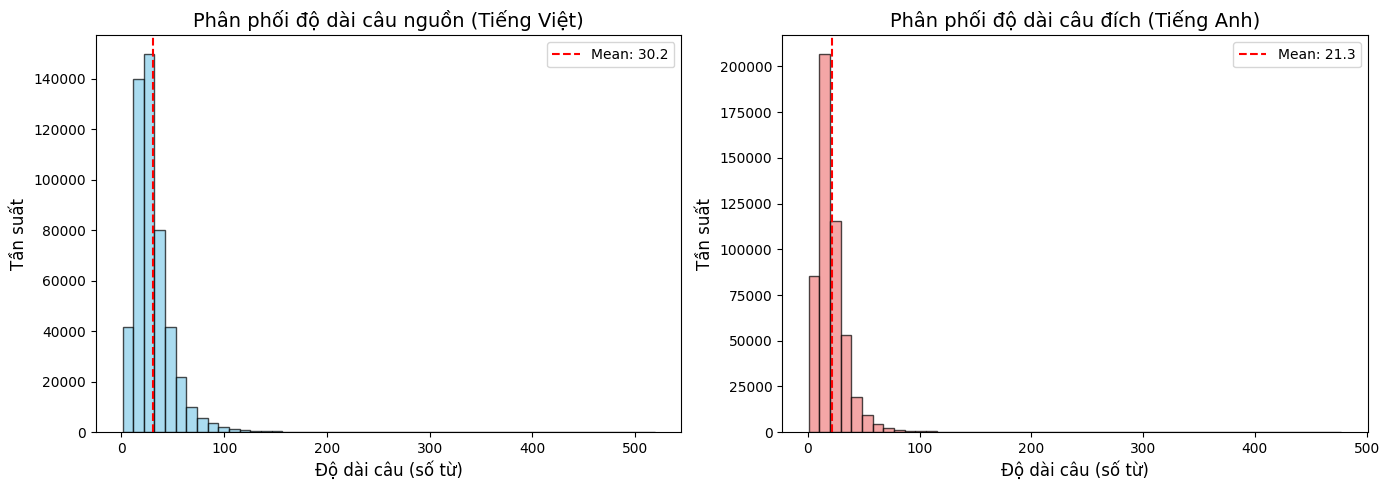

Min/Max src: 1/519
Min/Max tgt: 1/477


In [17]:
# Phân tích độ dài câu gốc (trước khi clean)
src_lengths = [len(s.split()) for s in train_src]
tgt_lengths = [len(t.split()) for t in train_tgt]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram cho source (Vietnamese)
axes[0].hist(src_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Độ dài câu (số từ)', fontsize=12)
axes[0].set_ylabel('Tần suất', fontsize=12)
axes[0].set_title('Phân phối độ dài câu nguồn (Tiếng Việt)', fontsize=14)
axes[0].axvline(x=sum(src_lengths)/len(src_lengths), color='red', linestyle='--', label=f'Mean: {sum(src_lengths)/len(src_lengths):.1f}')
axes[0].legend()

# Histogram cho target (English)
axes[1].hist(tgt_lengths, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Độ dài câu (số từ)', fontsize=12)
axes[1].set_ylabel('Tần suất', fontsize=12)
axes[1].set_title('Phân phối độ dài câu đích (Tiếng Anh)', fontsize=14)
axes[1].axvline(x=sum(tgt_lengths)/len(tgt_lengths), color='red', linestyle='--', label=f'Mean: {sum(tgt_lengths)/len(tgt_lengths):.1f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('length_distribution_raw.png', dpi=150)
plt.show()

print(f"Min/Max src: {min(src_lengths)}/{max(src_lengths)}")
print(f"Min/Max tgt: {min(tgt_lengths)}/{max(tgt_lengths)}")

## 3. Data Preprocessing

### 3.1 Define Cleaning Function

Our preprocessing pipeline includes:
- **Unicode normalization** (NFC form)
- **Smart quote replacement** (converting to ASCII equivalents)
- **Control character removal**
- **Optional lowercasing**
- **Punctuation filtering** (keep essential punctuation)
- **Whitespace normalization**
- **Sentence filtering** (3-100 words per sentence)
- **Duplicate removal**

In [18]:
def clean_sentence(sentence: str, lowercase: bool = True, preserve_punct: str = ".,:;/%-+()[]{}") -> str:
    if sentence is None:
        return ""

    # 1) Normalize unicode
    s = unicodedata.normalize('NFC', sentence)

    # 2) Replace smart quotes and nonstandard dashes with ASCII equivalents
    s = s.replace('“', '"').replace('”', '"').replace('‘', "'").replace('’', "'")
    s = s.replace('—', '-').replace('–', '-').replace('−', '-')

    # 3) Remove control characters
    s = ''.join(ch for ch in s if unicodedata.category(ch)[0] != 'C')

    # 4) Optionally lowercase
    if lowercase:
        s = s.lower()

    # 5) Remove unwanted punctuation but keep preserve_punct
    # Build set of punctuation to remove
    all_punct = set(string.punctuation)
    keep = set(preserve_punct)
    remove = ''.join(sorted(all_punct - keep))
    if remove:
        s = s.translate(str.maketrans('', '', remove))

    # 6) Normalize whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    # 7) Remove stray leading/trailing punctuation
    s = s.strip(" ".join(["'", '"', ".", ",", "-", ":", ";"]))

    return s

# Tạo pairs và clean
train_pairs_raw = list(zip(train_src, train_tgt))
test_pairs_raw = list(zip(test_src, test_tgt))
train_pairs = [(clean_sentence(src), clean_sentence(tgt)) for src, tgt in zip(train_src, train_tgt)]
test_pairs = [(clean_sentence(src), clean_sentence(tgt)) for src, tgt in zip(test_src, test_tgt)]

# Lọc sentences: min_len=3 words, max_len=100 words
min_len, max_len = 3, 100
train_pairs_filtered = [
    (src, tgt) for src, tgt in train_pairs
    if min_len <= len(src.split()) <= max_len 
    and min_len <= len(tgt.split()) <= max_len
]

test_pairs_filtered = [
    (src, tgt) for src, tgt in test_pairs
    if min_len <= len(src.split()) <= max_len 
    and min_len <= len(tgt.split()) <= max_len
]

train_pairs_filtered = list(dict.fromkeys(train_pairs_filtered))
test_pairs_filtered = list(dict.fromkeys(test_pairs_filtered))
# Báo cáo
print(f"\n📊 Sau khi lọc:")
print(f"   Train: {len(train_pairs_raw)} → {len(train_pairs_filtered)} pairs")
print(f"   Test: {len(test_pairs_raw)} → {len(test_pairs_filtered)} pairs")
print(f"   Loại bỏ: {len(train_pairs_raw) - len(train_pairs_filtered)} train pairs")


📊 Sau khi lọc:
   Train: 500000 → 343110 pairs
   Test: 3000 → 2976 pairs
   Loại bỏ: 156890 train pairs


### 3.2 Analyze Cleaned Data Distribution

Compare the sentence length distributions before and after cleaning to understand the impact of our preprocessing pipeline.

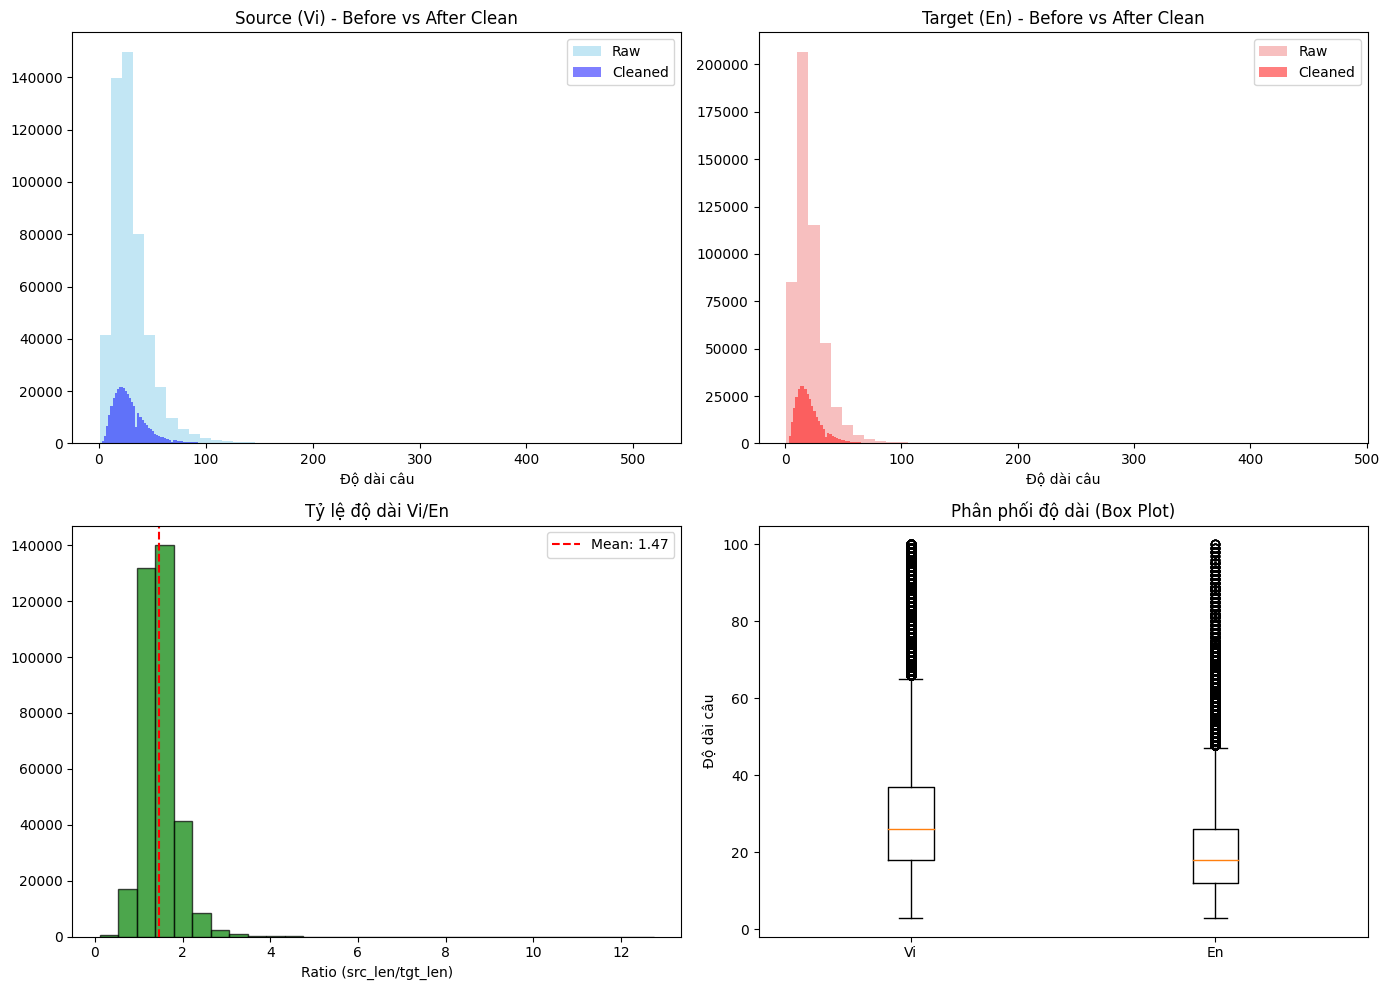

Số câu bị loại: 0 (0.0%)


In [19]:
# Phân phối sau khi clean và filter
src_lengths_clean = [len(s.split()) for s, _ in train_pairs_filtered]
tgt_lengths_clean = [len(t.split()) for _, t in train_pairs_filtered]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# So sánh source
axes[0, 0].hist(src_lengths, bins=50, color='skyblue', alpha=0.5, label='Raw')
axes[0, 0].hist(src_lengths_clean, bins=50, color='blue', alpha=0.5, label='Cleaned')
axes[0, 0].set_title('Source (Vi) - Before vs After Clean')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Độ dài câu')

# So sánh target
axes[0, 1].hist(tgt_lengths, bins=50, color='lightcoral', alpha=0.5, label='Raw')
axes[0, 1].hist(tgt_lengths_clean, bins=50, color='red', alpha=0.5, label='Cleaned')
axes[0, 1].set_title('Target (En) - Before vs After Clean')
axes[0, 1].legend()
axes[0, 1].set_xlabel('Độ dài câu')

# Tỷ lệ độ dài src/tgt
length_ratios = [len(s.split())/len(t.split()) for s, t in train_pairs_filtered]
axes[1, 0].hist(length_ratios, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Tỷ lệ độ dài Vi/En')
axes[1, 0].set_xlabel('Ratio (src_len/tgt_len)')
axes[1, 0].axvline(x=sum(length_ratios)/len(length_ratios), color='red', linestyle='--', 
                    label=f'Mean: {sum(length_ratios)/len(length_ratios):.2f}')
axes[1, 0].legend()

# Box plot so sánh
axes[1, 1].boxplot([src_lengths_clean, tgt_lengths_clean], labels=['Vi', 'En'])
axes[1, 1].set_title('Phân phối độ dài (Box Plot)')
axes[1, 1].set_ylabel('Độ dài câu')

plt.tight_layout()
plt.savefig('length_distribution_cleaned.png', dpi=150)
plt.show()

print(f"Số câu bị loại: {len(train_src) - len(train_pairs)} ({100*(len(train_src)-len(train_pairs))/len(train_src):.1f}%)")

## 4. Tokenization

### 4.1 Basic Word-Level Tokenization

First, we implement a simple word-level tokenizer that splits on whitespace and adds special tokens:
- `<SOS>` - Start of sequence
- `<EOS>` - End of sequence

In [ ]:
def tokenize(sentence: str) -> List[str]:
    """Tokenize: split words, thêm <SOS> và <EOS>."""
    tokens = sentence.split()
    return ['<SOS>'] + tokens + ['<EOS>']

# Tokenize tất cả
train_src_tokens = [tokenize(src) for src, _ in train_pairs_filtered]
train_tgt_tokens = [tokenize(tgt) for _, tgt in train_pairs_filtered]
test_src_tokens = [tokenize(src) for src, _ in test_pairs_filtered]
test_tgt_tokens = [tokenize(tgt) for _, tgt in test_pairs_filtered]

### 4.2 BPE (Byte-Pair Encoding) Tokenizer

We train (or load cached) separate BPE tokenizers for source (Vietnamese) and target (English) languages.

**Why BPE?**
- Handles **out-of-vocabulary words** by breaking them into subword units
- Works well with **morphologically rich languages**
- Provides **vocabulary size control** - balancing expressiveness and efficiency

**Special Tokens**: `<PAD>`, `<UNK>`, `<SOS>`, `<EOS>`

In [ ]:
from pathlib import Path
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

# Define paths
TOKENIZER_DIR.mkdir(exist_ok=True)
SRC_TOK_PATH = TOKENIZER_DIR / "src_tokenizer.json"
TGT_TOK_PATH = TOKENIZER_DIR / "tgt_tokenizer.json"

def get_or_train_tokenizer(text_data, vocab_size, path, label=""):
    if path.exists():
        print(f"📖 Loading existing {label} tokenizer from {path}...")
        return Tokenizer.from_file(str(path))
    else:
        print(f"🏋️ Training new {label} tokenizer...")
        tokenizer = Tokenizer(models.BPE(unk_token="<UNK>"))
        tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
        
        trainer = trainers.BpeTrainer(
            special_tokens=["<PAD>", "<UNK>", "<SOS>", "<EOS>"],
            vocab_size=vocab_size,
            min_frequency=2
        )
        tokenizer.train_from_iterator(text_data, trainer)
        
        # SAVE THE TOKENIZER
        tokenizer.save(str(path))
        print(f"💾 Saved {label} tokenizer to {path}")
        return tokenizer

# Usage
src_tokenizer = get_or_train_tokenizer(train_src, 32000, SRC_TOK_PATH, "Source")
tgt_tokenizer = get_or_train_tokenizer(train_tgt, 32000, TGT_TOK_PATH, "Target")

print(f"Src Vocab: {src_tokenizer.get_vocab_size()}")
print(f"Tgt Vocab: {tgt_tokenizer.get_vocab_size()}")

## 5. Dataset and DataLoader Preparation

### 5.1 PyTorch Dataset and Sampler Classes

Create a custom `TranslationDataset` class and implement `BucketSampler` for efficient batching:
- Groups sequences of similar lengths together
- Reduces padding waste
- Improves training efficiency

In [20]:
import torch
import math
import random
from torch.utils.data import Dataset, Sampler, DataLoader, random_split
from typing import List

use_cuda = torch.cuda.is_available()

class TranslationDataset(Dataset):
    # Changed type hint to allow lists of tensors
    def __init__(self, src_data, tgt_data):
        self.src = src_data
        self.tgt = tgt_data
    
    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]

# --- NEW: Collate Function for Dynamic Padding ---
def dynamic_padding_collate(batch):
    """
    Pads batches on the fly to the longest sequence IN THAT BATCH, 
    not the longest in the entire dataset.
    """
    src_batch, tgt_batch = zip(*batch)
    
    # We rely on the pad_ids being available in the global scope 
    # (defined in the next cell) or passed in. 
    # For simplicity in this notebook structure, we use the global vars.
    
    # Pad src
    src_padded = torch.nn.utils.rnn.pad_sequence(
        src_batch, batch_first=True, padding_value=src_pad_idx
    )
    # Pad tgt
    tgt_padded = torch.nn.utils.rnn.pad_sequence(
        tgt_batch, batch_first=True, padding_value=tgt_pad_idx
    )
    
    return src_padded, tgt_padded

class BucketBatchSampler(Sampler[List[int]]):
    def __init__(
        self,
        lengths: List[int],
        batch_size: int,
        bucket_size_multiplier: int = 100,
        shuffle: bool = True,
        drop_last: bool = False,
        seed: int = 42,
    ):
        self.lengths = lengths
        self.batch_size = batch_size
        self.bucket_size = batch_size * bucket_size_multiplier
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.seed = seed

    def __iter__(self):
        indices = list(range(len(self.lengths)))
        rng = random.Random(self.seed)
        if self.shuffle:
            rng.shuffle(indices)
        
        # Create buckets
        for bucket_start in range(0, len(indices), self.bucket_size):
            bucket = indices[bucket_start:bucket_start + self.bucket_size]
            # Sort indices in this bucket by sequence length to minimize padding
            bucket.sort(key=lambda idx: self.lengths[idx])
            
            # Yield batches from the sorted bucket
            for batch_start in range(0, len(bucket), self.batch_size):
                batch = bucket[batch_start:batch_start + self.batch_size]
                if len(batch) < self.batch_size and self.drop_last:
                    continue
                yield batch
        
        if self.shuffle:
            self.seed = rng.randint(0, 1_000_000_000)

    def __len__(self) -> int:
        total = len(self.lengths)
        if self.drop_last:
            return total // self.batch_size
        return math.ceil(total / self.batch_size)

def build_dataloader(dataset: TranslationDataset, lengths: List[int], batch_size: int, shuffle: bool = True) -> DataLoader:
    sampler = BucketBatchSampler(lengths, batch_size=batch_size, shuffle=shuffle)
    return DataLoader(
        dataset,
        batch_sampler=sampler,
        collate_fn=dynamic_padding_collate,
        pin_memory=use_cuda,
        num_workers=4,
    )

### 5.2 Prepare Training and Validation Sets

Encode all sentences using BPE tokenizers, create data loaders with:
- **Variable-length encoding** (no pre-padding)
- **Dynamic batching** with bucket sampling
- **Validation split** (10%)

In [21]:
src_pad_id = src_tokenizer.token_to_id("<PAD>")
tgt_pad_id = tgt_tokenizer.token_to_id("<PAD>")
src_pad_idx = src_pad_id
tgt_pad_idx = tgt_pad_id
sos_idx = tgt_tokenizer.token_to_id("<SOS>")
eos_idx = tgt_tokenizer.token_to_id("<EOS>")

val_ratio = 0.1
batch_size = 64

# 1. Define Encoding Function using BPE
def encode_with_bpe_variable(tokenizer, sentences, max_len=128):
    sos_id = tokenizer.token_to_id("<SOS>")
    eos_id = tokenizer.token_to_id("<EOS>")
    
    indices_list = []
    encoded_batch = tokenizer.encode_batch(sentences)
    
    for enc in encoded_batch:
        ids = enc.ids
        # Truncate
        if len(ids) > max_len - 2:
            ids = ids[:max_len - 2]
        
        # Add special tokens
        ids = [sos_id] + ids + [eos_id]
        
        # Save as 1D tensor (Variable Length)
        indices_list.append(torch.tensor(ids, dtype=torch.long))
    
    return indices_list

print("Encoding Data with BPE (Variable Length)...")
# 2. Generate Lists of 1D Tensors
train_src_list = encode_with_bpe_variable(src_tokenizer, train_src, max_len=max_seq_len)
train_tgt_list = encode_with_bpe_variable(tgt_tokenizer, train_tgt, max_len=max_seq_len)
test_src_list  = encode_with_bpe_variable(src_tokenizer, test_src,  max_len=max_seq_len)
test_tgt_list  = encode_with_bpe_variable(tgt_tokenizer, test_tgt,  max_len=max_seq_len)

# 3. Calculate lengths for the BucketSampler
train_lengths = [len(x) for x in train_src_list]
test_lengths = [len(x) for x in test_src_list]

# 4. Create Datasets
train_dataset = TranslationDataset(train_src_list, train_tgt_list)
test_dataset = TranslationDataset(test_src_list, test_tgt_list)

# 5. Split Train/Val
val_size = max(1, int(len(train_dataset) * val_ratio))
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(
    train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42),
)

# Extract lengths for subsets
train_subset_lengths = [train_lengths[i] for i in train_subset.indices]
val_subset_lengths = [train_lengths[i] for i in val_subset.indices]

# 6. Build DataLoaders
train_loader = build_dataloader(train_subset, train_subset_lengths, batch_size=batch_size, shuffle=True)
val_loader = build_dataloader(val_subset, val_subset_lengths, batch_size=batch_size, shuffle=False)
test_loader = build_dataloader(test_dataset, test_lengths, batch_size=batch_size, shuffle=False)

print(f"DataLoaders ready.")

Encoding Data with BPE (Variable Length)...
DataLoaders ready.


### 5.3 Vocabulary Analysis

Analyze the word frequency distribution in both source and target vocabularies to understand:
- Most common words
- Vocabulary coverage
- Rare words distribution

In [22]:
# Phân tích vocab
# Đếm tần suất từ trong corpus
src_word_freq = Counter()
for tokens in train_src_tokens:
    src_word_freq.update([t for t in tokens if t not in ['<SOS>', '<EOS>']])

tgt_word_freq = Counter()
for tokens in train_tgt_tokens:
    tgt_word_freq.update([t for t in tokens if t not in ['<SOS>', '<EOS>']])

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Top 20 từ phổ biến - Source
top_src = src_word_freq.most_common(20)
axes[0, 0].barh([w for w, _ in top_src][::-1], [c for _, c in top_src][::-1], color='skyblue')
axes[0, 0].set_title('Top 20 từ phổ biến - Tiếng Việt')
axes[0, 0].set_xlabel('Tần suất')

# Top 20 từ phổ biến - Target
top_tgt = tgt_word_freq.most_common(20)
axes[0, 1].barh([w for w, _ in top_tgt][::-1], [c for _, c in top_tgt][::-1], color='lightcoral')
axes[0, 1].set_title('Top 20 từ phổ biến - Tiếng Anh')
axes[0, 1].set_xlabel('Tần suất')

# Phân phối tần suất từ (log scale)
src_freqs = sorted(src_word_freq.values(), reverse=True)
tgt_freqs = sorted(tgt_word_freq.values(), reverse=True)

axes[1, 0].plot(range(1, len(src_freqs)+1), src_freqs, color='blue', alpha=0.7, label='Vi')
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].set_title('Phân phối tần suất từ - Zipf\'s Law (Vi)')
axes[1, 0].set_xlabel('Rank (log)')
axes[1, 0].set_ylabel('Frequency (log)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(range(1, len(tgt_freqs)+1), tgt_freqs, color='red', alpha=0.7, label='En')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Phân phối tần suất từ - Zipf\'s Law (En)')
axes[1, 1].set_xlabel('Rank (log)')
axes[1, 1].set_ylabel('Frequency (log)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vocab_distribution.png', dpi=150)
plt.show()

# Báo cáo vocab coverage
print(f"\nVocab Coverage Analysis:")
print(f"Số từ xuất hiện 1 lần (Vi): {sum(1 for f in src_word_freq.values() if f == 1)} ({sum(1 for f in src_word_freq.values() if f == 1)/len(src_word_freq)*100:.1f}%)")
print(f"Số từ xuất hiện 1 lần (En): {sum(1 for f in tgt_word_freq.values() if f == 1)} ({sum(1 for f in tgt_word_freq.values() if f == 1)/len(tgt_word_freq)*100:.1f}%)")
print(f"Số từ xuất hiện >=5 lần (Vi): {sum(1 for f in src_word_freq.values() if f >= 5)}")
print(f"Số từ xuất hiện >=5 lần (En): {sum(1 for f in tgt_word_freq.values() if f >= 5)}")

NameError: name 'train_src_tokens' is not defined

### 5.4 Analyze Sequence Length Distribution

Examine the actual sequence lengths after BPE encoding to understand:
- Token-level length distribution
- Source vs target length ratio
- Data utilization efficiency

In [ ]:
import matplotlib.pyplot as plt

# 1. Calculate lengths directly from the list of tensors
# (Since we haven't padded them yet, the tensor length IS the actual length)
train_src_actual_lens = [len(x) for x in train_src_list]
train_tgt_actual_lens = [len(x) for x in train_tgt_list]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram: Source Lengths
axes[0].hist(train_src_actual_lens, bins=40, color='skyblue', alpha=0.7, edgecolor='black')
axes[0].set_title('Sequence Lengths - Source (Vi)')
axes[0].set_xlabel('Length')
axes[0].set_ylabel('Count')
axes[0].axvline(x=max_seq_len, color='red', linestyle='--', label=f'Max: {max_seq_len}')
axes[0].legend()

# Histogram: Target Lengths
axes[1].hist(train_tgt_actual_lens, bins=40, color='lightcoral', alpha=0.7, edgecolor='black')
axes[1].set_title('Sequence Lengths - Target (En)')
axes[1].set_xlabel('Length')
axes[1].axvline(x=max_seq_len, color='red', linestyle='--', label=f'Max: {max_seq_len}')
axes[1].legend()

# Analysis: "Wasted Space" if we had used Static Padding
# This shows why Dynamic Padding is so much faster!
wasted_space_ratios = [(max_seq_len - actual_len) / max_seq_len * 100 
                  for actual_len in train_src_actual_lens]

axes[2].hist(wasted_space_ratios, bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[2].set_title('Space Saved by Dynamic Padding')
axes[2].set_xlabel('% Empty Space Avoided')
axes[2].set_ylabel('Count')
axes[2].axvline(x=sum(wasted_space_ratios)/len(wasted_space_ratios), color='red', linestyle='--',
                label=f'Avg Savings: {sum(wasted_space_ratios)/len(wasted_space_ratios):.1f}%')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"Total Source Sentences: {len(train_src_actual_lens)}")
print(f"Sentences truncated (Vi): {sum(1 for l in train_src_actual_lens if l >= max_seq_len)}")
print(f"Sentences truncated (En): {sum(1 for l in train_tgt_actual_lens if l >= max_seq_len)}")

## 6. Transformer Model Architecture

Now we implement the Transformer architecture from scratch following the "Attention Is All You Need" paper (Vaswani et al., 2017).

### 6.1 Input Embeddings and Positional Encoding

- **Input Embeddings**: Convert token indices to dense vectors of dimension `d_model`
- **Positional Encoding**: Add sinusoidal position information since Transformers have no inherent notion of sequence order

$$PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d_{model}})$$

In [2]:
import copy
import math
from typing import Any, Callable, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------
# Embeddings & Positional Enc
# -----------------------------
class InputEmbeddings(nn.Module):
    def __init__(self, d_model: int, vocab_size: int, padding_idx: Optional[int] = None):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=padding_idx)

    def forward(self, x: torch.LongTensor) -> torch.Tensor:
        # x: (batch, seq)
        return self.embedding(x) * math.sqrt(self.d_model)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model, dtype=torch.float32)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe, persistent=False)

    def forward(self, x: torch.Tensor, start_pos: int = 0) -> torch.Tensor:
        seq_len = x.size(1)
        # Use start_pos to slice the correct positions
        pe_slice = self.pe[:, start_pos : start_pos + seq_len, :].to(dtype=x.dtype, device=x.device)
        x = x + pe_slice
        return self.dropout(x)

### 6.2 Layer Normalization

Implement layer normalization with learnable scale (gamma) and shift (beta) parameters:
- Normalizes across the feature dimension
- Essential for training stability
- Used in Pre-LN Transformer variant

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Callable

class LayerNormalization(nn.Module):
    def __init__(self, features: int, eps: float = 1e-5, elementwise_affine: bool = True):
        super().__init__()
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if elementwise_affine:
            # keep names compatible with your checkpoints (alpha, bias)
            self.alpha = nn.Parameter(torch.ones(features))
            self.bias = nn.Parameter(torch.zeros(features))
        else:
            self.register_parameter("alpha", None)
            self.register_parameter("bias", None)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # compute moments in float32 for stability when x is fp16/bfloat16
        orig_dtype = x.dtype
        if orig_dtype in (torch.float16, torch.bfloat16):
            x_float = x.float()
        else:
            x_float = x

        mean = x_float.mean(dim=-1, keepdim=True)
        var = x_float.var(dim=-1, keepdim=True, unbiased=False)
        x_norm = (x_float - mean) / torch.sqrt(var + self.eps)

        if orig_dtype in (torch.float16, torch.bfloat16):
            x_norm = x_norm.to(orig_dtype)

        if self.elementwise_affine:
            alpha = self.alpha.to(x_norm.dtype).to(x_norm.device)
            bias = self.bias.to(x_norm.dtype).to(x_norm.device)
            return alpha * x_norm + bias
        return x_norm


class FeedForwardBlock(nn.Module):
    def __init__(
        self,
        model_dim: int,
        hidden_dim: int,
        dropout: float = 0.1,
        activation: Optional[Callable] = None,
        activation_name: Optional[str] = "gelu",
        final_dropout: Optional[float] = None,
    ):
        super().__init__()
        self.linear1 = nn.Linear(model_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, model_dim)
        self.dropout = nn.Dropout(dropout)
        self.final_dropout = nn.Dropout(dropout if final_dropout is None else final_dropout)

        if activation is not None:
            self.activation = activation
        else:
            name = (activation_name or "gelu").lower()
            if name == "gelu":
                self.activation = F.gelu
            elif name == "relu":
                self.activation = F.relu
            elif name in ("silu", "swish"):
                self.activation = F.silu
            else:
                raise ValueError(f"Unsupported activation: {name}")

        # sensible init
        nn.init.xavier_uniform_(self.linear1.weight)
        if self.linear1.bias is not None:
            nn.init.zeros_(self.linear1.bias)
        nn.init.xavier_uniform_(self.linear2.weight)
        if self.linear2.bias is not None:
            nn.init.zeros_(self.linear2.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.linear1(x)
        h = self.activation(h)
        h = self.dropout(h)
        out = self.linear2(h)
        out = self.final_dropout(out)
        return out

### 6.3 Multi-Head Attention

The core mechanism of the Transformer - allows the model to jointly attend to information from different representation subspaces at different positions.

**Key Components**:
- **Query (Q)**, **Key (K)**, **Value (V)** projections
- **Scaled Dot-Product Attention**: `softmax(QK^T / √d_k) × V`
- **Multiple attention heads** for diverse representations
- **Output projection** to combine head outputs

In [4]:
# -----------------------------
# Multi-Head Attention
# -----------------------------
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1, bias: bool = True):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.w_q = nn.Linear(d_model, d_model, bias=bias)
        self.w_k = nn.Linear(d_model, d_model, bias=bias)
        self.w_v = nn.Linear(d_model, d_model, bias=bias)
        self.w_o = nn.Linear(d_model, d_model, bias=bias)
        self.dropout = nn.Dropout(dropout)
        self.scaling = 1.0 / math.sqrt(self.d_k)

    @staticmethod
    def _expand_for_heads(x: torch.Tensor, num_heads: int) -> torch.Tensor:
        b, seq_len, d_model = x.size()
        d_k = d_model // num_heads
        return x.view(b, seq_len, num_heads, d_k).transpose(1, 2)  # (b,h,seq,d_k)

    @staticmethod
    def _maybe_cast_for_softmax(t: torch.Tensor) -> Tuple[torch.Tensor, bool]:
        if t.dtype in (torch.float16, torch.bfloat16):
            t = t.float()
            return t, True
        return t, False

    def forward(
        self,
        q: torch.Tensor,
        k: torch.Tensor,
        v: torch.Tensor,
        attn_mask: Optional[torch.Tensor] = None,
        key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = False,
        past_key_value: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]:
        """
        q,k,v: (batch, seq, d_model)
        past_key_value: optional (k_cache, v_cache) with shape (batch, heads, seq_cached, d_k)
        returns: (output, attn_weights or None, present_key_value)
        """
        b, seq_q, _ = q.size()

        q_proj = self.w_q(q)
        k_proj = self.w_k(k)
        v_proj = self.w_v(v)

        qh = self._expand_for_heads(q_proj, self.num_heads)  # (b,h,seq_q,d_k)
        kh = self._expand_for_heads(k_proj, self.num_heads)  # (b,h,seq_k,d_k)
        vh = self._expand_for_heads(v_proj, self.num_heads)  # (b,h,seq_k,d_k)

        if past_key_value is not None:
            past_k, past_v = past_key_value                   # (b,h,seq_cached,d_k)
            kh = torch.cat([past_k, kh], dim=2)
            vh = torch.cat([past_v, vh], dim=2)
        present_key_value = (kh, vh)

        scores = torch.matmul(qh, kh.transpose(-2, -1)) * self.scaling  # (b,h,seq_q,seq_k)

        if key_padding_mask is not None:
            kpm = key_padding_mask.unsqueeze(1).unsqueeze(2)   # (b,1,1,seq_k)
            scores = scores.masked_fill(kpm, float('-inf'))

        if attn_mask is not None:
            # attn_mask: broadcast to (b,h,seq_q,seq_k)
            if attn_mask.dim() == 2:
                attn_mask = attn_mask.unsqueeze(0).unsqueeze(0)
            elif attn_mask.dim() == 3:
                attn_mask = attn_mask.unsqueeze(1)
            scores = scores.masked_fill(attn_mask, float('-inf'))

        scores_for_sm, was_cast = self._maybe_cast_for_softmax(scores)
        attn_weights = F.softmax(scores_for_sm, dim=-1)
        if was_cast:
            attn_weights = attn_weights.to(scores.dtype)

        attn_weights = self.dropout(attn_weights)
        attn_output = torch.matmul(attn_weights, vh)          # (b,h,seq_q,d_k)
        attn_output = attn_output.transpose(1, 2).contiguous().view(b, seq_q, self.d_model)
        out = self.w_o(attn_output)

        if not need_weights:
            attn_weights_out = None
        else:
            attn_weights_out = attn_weights.mean(dim=1)       # (b,seq_q,seq_k)

        return out, attn_weights_out, present_key_value


### 6.4 Residual Connections

Implement residual (skip) connections with layer normalization using **Pre-LN** (layer norm before sublayer) for better training stability.

**Architecture**: `x + Dropout(Sublayer(LayerNorm(x)))`

In [5]:
# -----------------------------
# Residual
# -----------------------------
class ResidualConnection(nn.Module):
    def __init__(self, d_model: int, dropout: float, eps: float = 1e-5):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization(d_model, eps)

    def forward(self, x: torch.Tensor, sublayer_out: torch.Tensor) -> torch.Tensor:
        # pre-norm is handled by caller: caller will compute sublayer_out using self.norm(x)
        return x + self.dropout(sublayer_out)

### 6.5 Encoder and Decoder Layers

Each layer in the Transformer stack:

**Encoder Layer**:
1. Self-attention (with residual)
2. Feed-forward network (with residual)

**Decoder Layer**:
1. Masked self-attention (with residual) - prevents attending to future tokens
2. Cross-attention over encoder output (with residual)
3. Feed-forward network (with residual)

In [6]:
# -----------------------------
# Layers
# -----------------------------
class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, h: int, d_ff: int, dropout: float):
        super().__init__()
        self.self_attention_block = MultiHeadAttention(d_model, h, dropout)
        self.feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        self.residual_connections = nn.ModuleList([
            ResidualConnection(d_model, dropout),
            ResidualConnection(d_model, dropout),
        ])

    def forward(
        self,
        x: torch.Tensor,
        src_attn_mask: Optional[torch.Tensor] = None,
        src_key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = False,
    ):
        # self\-attention
        norm_x = self.residual_connections[0].norm(x)
        attn_out, attn_w, _ = self.self_attention_block(
            norm_x,
            norm_x,
            norm_x,
            attn_mask=src_attn_mask,
            key_padding_mask=src_key_padding_mask,
            need_weights=need_weights,
            past_key_value=None,
        )
        x = self.residual_connections[0](x, attn_out)

        # feed\-forward
        norm_x = self.residual_connections[1].norm(x)
        ff_out = self.feed_forward_block(norm_x)
        x = self.residual_connections[1](x, ff_out)

        if need_weights:
            return x, attn_w
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model: int, h: int, d_ff: int, dropout: float):
        super().__init__()
        self.self_attention_block = MultiHeadAttention(d_model, h, dropout)
        self.cross_attention_block = MultiHeadAttention(d_model, h, dropout)
        self.feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        self.residual_connections = nn.ModuleList([
            ResidualConnection(d_model, dropout),
            ResidualConnection(d_model, dropout),
            ResidualConnection(d_model, dropout),
        ])

    def forward(
        self,
        x: torch.Tensor,
        encoder_output: torch.Tensor,
        tgt_attn_mask: Optional[torch.Tensor] = None,
        memory_attn_mask: Optional[torch.Tensor] = None,
        tgt_key_padding_mask: Optional[torch.Tensor] = None,
        memory_key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = False,
        past_self_kv: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
    ):
        # self-attn with cache
        norm_x = self.residual_connections[0].norm(x)
        self_attn_out, self_attn_w, present_self_kv = self.self_attention_block(
            norm_x, norm_x, norm_x,
            attn_mask=tgt_attn_mask,
            key_padding_mask=tgt_key_padding_mask,
            need_weights=need_weights,
            past_key_value=past_self_kv,
        )
        x = self.residual_connections[0](x, self_attn_out)

        # cross-attn (no cache)
        norm_x = self.residual_connections[1].norm(x)
        cross_attn_out, cross_attn_w, _ = self.cross_attention_block(
            norm_x, encoder_output, encoder_output,
            attn_mask=memory_attn_mask,
            key_padding_mask=memory_key_padding_mask,
            need_weights=need_weights,
            past_key_value=None,
        )
        x = self.residual_connections[1](x, cross_attn_out)

        # FFN
        norm_x = self.residual_connections[2].norm(x)
        ff_out = self.feed_forward_block(norm_x)
        x = self.residual_connections[2](x, ff_out)

        if need_weights:
            return x, self_attn_w, cross_attn_w, present_self_kv
        return x, None, None, present_self_kv

### 6.6 Complete Encoder, Decoder, and Transformer

Stack multiple encoder/decoder layers and combine into the full Transformer:
- **Encoder**: N layers of self-attention + FFN
- **Decoder**: N layers of masked self-attention + cross-attention + FFN
- **Projection Layer**: Maps decoder output to vocabulary size

In [7]:
# -----------------------------
# Encoder / Decoder stacks + Projection + Transformer
# -----------------------------

class Encoder(nn.Module):
    def __init__(self, layers: List[nn.Module], d_model: int):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = LayerNormalization(d_model)

    def forward(
        self,
        x: torch.Tensor,
        src_attn_mask: Optional[torch.Tensor] = None,
        src_key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = False,
    ):
        attn_weights_all = [] if need_weights else None

        for layer in self.layers:
            if need_weights:
                x, attn = layer(
                    x,
                    src_attn_mask=src_attn_mask,
                    src_key_padding_mask=src_key_padding_mask,
                    need_weights=True,
                )
                attn_weights_all.append(attn)
            else:
                x = layer(
                    x,
                    src_attn_mask=src_attn_mask,
                    src_key_padding_mask=src_key_padding_mask,
                    need_weights=False,
                )

        x = self.norm(x)
        if need_weights:
            return x, attn_weights_all
        return x


class Decoder(nn.Module):
    def __init__(self, layers: List[nn.Module], d_model: int):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = LayerNormalization(d_model)

    def forward(
        self,
        x: torch.Tensor,
        encoder_output: torch.Tensor,
        tgt_attn_mask: Optional[torch.Tensor] = None,
        memory_attn_mask: Optional[torch.Tensor] = None,
        tgt_key_padding_mask: Optional[torch.Tensor] = None,
        memory_key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = False,
        past_kv: Optional[List[Tuple[torch.Tensor, torch.Tensor]]] = None,
    ):
        self_attn_all = [] if need_weights else None
        cross_attn_all = [] if need_weights else None
        present_kv = []

        for i, layer in enumerate(self.layers):
            layer_past = None if past_kv is None else past_kv[i]
            x, self_w, cross_w, layer_present_kv = layer(
                x,
                encoder_output,
                tgt_attn_mask=tgt_attn_mask,
                memory_attn_mask=memory_attn_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask,
                need_weights=need_weights,
                past_self_kv=layer_past,
            )
            present_kv.append(layer_present_kv)
            if need_weights:
                self_attn_all.append(self_w)
                cross_attn_all.append(cross_w)

        x = self.norm(x)
        if need_weights:
            return x, self_attn_all, cross_attn_all, present_kv
        return x, present_kv


class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int, bias: bool = True, apply_log_softmax: bool = False):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size, bias=bias)
        self.apply_log_softmax = apply_log_softmax

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        logits = self.proj(x)
        if self.apply_log_softmax:
            return torch.log_softmax(logits, dim=-1)
        return logits

    def tie_to_embedding(self, embedding_module: nn.Embedding):
        if not isinstance(embedding_module, nn.Embedding):
            raise TypeError("embedding_module must be nn.Embedding")
        # Share weight (Parameter)
        self.proj.weight = embedding_module.weight
        return self


class Transformer(nn.Module):
    def __init__(
        self,
        encoder: Encoder,
        decoder: Decoder,
        src_embed: nn.Module,
        tgt_embed: nn.Module,
        src_pos: nn.Module,
        tgt_pos: nn.Module,
        projection_layer: ProjectionLayer,
    ):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(
        self,
        src: torch.Tensor,
        src_attn_mask: Optional[torch.Tensor] = None,
        src_key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = False,
    ):
        x = self.src_embed(src)
        x = self.src_pos(x)
        return self.encoder(x, src_attn_mask=src_attn_mask, src_key_padding_mask=src_key_padding_mask, need_weights=need_weights)

    # New explicit API
    def decode(
        self,
        encoder_output: torch.Tensor,
        tgt: torch.Tensor,
        tgt_attn_mask: Optional[torch.Tensor] = None,
        memory_attn_mask: Optional[torch.Tensor] = None,
        tgt_key_padding_mask: Optional[torch.Tensor] = None,
        memory_key_padding_mask: Optional[torch.Tensor] = None,
        need_weights: bool = False,
        past_kv: Optional[List[Tuple[torch.Tensor, torch.Tensor]]] = None,
    ):
        y = self.tgt_embed(tgt)
        y = self.tgt_pos(y)
        if need_weights:
            dec_out, self_w, cross_w, present_kv = self.decoder(
                y,
                encoder_output,
                tgt_attn_mask=tgt_attn_mask,
                memory_attn_mask=memory_attn_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask,
                need_weights=True,
                past_kv=past_kv,
            )
            return dec_out, self_w, cross_w, present_kv
        else:
            dec_out, present_kv = self.decoder(
                y,
                encoder_output,
                tgt_attn_mask=tgt_attn_mask,
                memory_attn_mask=memory_attn_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask,
                past_kv=past_kv,
            )
            return dec_out, present_kv

    def project(self, x: torch.Tensor) -> torch.Tensor:
        return self.projection_layer(x)

### 6.7 Helper Functions and Model Builder

Utility functions for:
- **`clones_deep`**: Creating multiple identical layers via deep copy
- **`build_transformer`**: Factory function to construct the complete model
- **Mask creation**: Padding masks and causal (look-ahead) masks

In [8]:
# -----------------------------
# helpers: clone / build / masks
# -----------------------------
def clones_deep(module: nn.Module, N: int) -> nn.ModuleList:
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


def build_transformer(
    src_vocab_size: int,
    tgt_vocab_size: int,
    src_max_len: int,
    tgt_max_len: int,
    d_model: int = 512,
    N: int = 6,
    h: int = 8,
    dropout: float = 0.1,
    d_ff: int = 2048,
    src_padding_idx: int = 0,
    tgt_padding_idx: int = 0,
    tie_weights: bool = True,
) -> Transformer:
    src_embed = InputEmbeddings(d_model=d_model, vocab_size=src_vocab_size, padding_idx=src_padding_idx)
    tgt_embed = InputEmbeddings(d_model=d_model, vocab_size=tgt_vocab_size, padding_idx=tgt_padding_idx)
    src_pos = PositionalEncoding(d_model=d_model, max_len=src_max_len, dropout=dropout)
    tgt_pos = PositionalEncoding(d_model=d_model, max_len=tgt_max_len, dropout=dropout)

    enc_proto = EncoderLayer(d_model=d_model, h=h, d_ff=d_ff, dropout=dropout)
    dec_proto = DecoderLayer(d_model=d_model, h=h, d_ff=d_ff, dropout=dropout)

    encoder = Encoder(clones_deep(enc_proto, N), d_model=d_model)
    decoder = Decoder(clones_deep(dec_proto, N), d_model=d_model)

    proj = ProjectionLayer(d_model=d_model, vocab_size=tgt_vocab_size, apply_log_softmax=False)
    model = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, proj)

    # init: xavier for linear weights
    for name, p in model.named_parameters():
        if p.requires_grad:
            if p.ndim > 1:
                nn.init.xavier_uniform_(p)
            else:
                if "bias" in name:
                    nn.init.zeros_(p)

    # tie weights
    if tie_weights:
        # target embedding may be wrapper
        emb = getattr(tgt_embed, "embedding", tgt_embed)
        if isinstance(emb, nn.Embedding):
            proj.tie_to_embedding(emb)
        else:
            raise TypeError("Unable to tie weights: tgt_embed has no nn.Embedding accessible as .embedding")

    return model


# Mask helpers (new API)
def make_padding_key_mask(seq: torch.Tensor, pad_idx: int = 0) -> torch.Tensor:
    # returns (batch, seq) bool True==padding
    return (seq == pad_idx)


def make_causal_attn_mask(seq_len: int, device: Optional[torch.device] = None) -> torch.Tensor:
    # returns (seq_len, seq_len) bool True==masked (upper triangle above diagonal)
    mask = torch.triu(torch.ones((seq_len, seq_len), device=device, dtype=torch.bool), diagonal=1)
    return mask


def combine_target_masks(tgt_seq: torch.Tensor, pad_idx: int = 0) -> Tuple[torch.Tensor, torch.Tensor]:
    # returns (tgt_attn_mask (seq,seq), tgt_key_padding_mask (batch, seq))
    tgt_seq_len = tgt_seq.size(1)
    tgt_attn_mask = make_causal_attn_mask(tgt_seq_len, device=tgt_seq.device)
    tgt_key_padding_mask = make_padding_key_mask(tgt_seq, pad_idx=pad_idx)
    return tgt_attn_mask, tgt_key_padding_mask


def create_masks(src: torch.Tensor, tgt: torch.Tensor, pad_idx: int = 0) -> Tuple[
    torch.Tensor, torch.Tensor, torch.Tensor]:
    # returns (src_key_padding_mask, tgt_attn_mask, tgt_key_padding_mask)
    src_key_padding_mask = make_padding_key_mask(src, pad_idx=pad_idx)
    tgt_attn_mask, tgt_key_padding_mask = combine_target_masks(tgt, pad_idx=pad_idx)
    return src_key_padding_mask, tgt_attn_mask, tgt_key_padding_mask


def create_masks_legacy(src: torch.Tensor, tgt: torch.Tensor, pad_idx: int = 0) -> Tuple[torch.Tensor, torch.Tensor]:
    # backward-compatible shapes: (batch,1,1,src_seq), (batch,1,tgt_seq,tgt_seq)
    src_kpm = make_padding_key_mask(src, pad_idx=pad_idx)  # (batch, src_seq) True==pad
    src_padding_broadcast = src_kpm.unsqueeze(1).unsqueeze(2)  # (batch,1,1,src_seq)

    tgt_attn = make_causal_attn_mask(tgt.size(1), device=tgt.device)  # (tgt_seq, tgt_seq)
    tgt_kpm = make_padding_key_mask(tgt, pad_idx=pad_idx)  # (batch, tgt_seq)
    causal_b = tgt_attn.unsqueeze(0).unsqueeze(0).to(device=tgt.device)  # (1,1,tgt_seq,tgt_seq)
    padding_b = tgt_kpm.unsqueeze(1).unsqueeze(-1)  # (batch,1,tgt_seq,1)
    tgt_combined = causal_b | padding_b  # (batch,1,tgt_seq,tgt_seq)
    return src_padding_broadcast, tgt_combined

## 7. Training Utilities

### 7.1 Token Conversion and Detokenization

Functions to convert between token indices and text for evaluation and visualization:
- `indices_to_tokens`: Convert indices to token strings
- `detokenize`: Join tokens into readable text
- `indices_to_text`: End-to-end conversion using tokenizer

In [ ]:
def indices_to_tokens(indices: torch.Tensor, vocab: Dict[str, int]) -> List[str]:
    inv_vocab = {idx: token for token, idx in vocab.items()}
    return [inv_vocab.get(idx.item(), '<UNK>') for idx in indices]


def detokenize(tokens: List[str]) -> str:
    filtered = [tok for tok in tokens if tok not in {'<SOS>', '<EOS>', '<PAD>'}]
    return ' '.join(filtered)

def indices_to_text(tokenizer, indices):
    # Convert tensor to list
    if isinstance(indices, torch.Tensor):
        indices = indices.tolist()
        
    # Decode (skip_special_tokens=True removes SOS, EOS, PAD automatically)
    return tokenizer.decode(indices, skip_special_tokens=True)


use_cuda = torch.cuda.is_available() and torch.cuda.device_count() > 0
if use_cuda:
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"⚡ Using CUDA device {current_device}: {device_name}")
else:
    print("⚠️ CUDA unavailable, running on CPU.")
device = torch.device('cuda' if use_cuda else 'cpu')
model_config = {
    'src_vocab_size': src_tokenizer.get_vocab_size(),
    'tgt_vocab_size': tgt_tokenizer.get_vocab_size(),
    
    'src_max_len': max_seq_len,
    'tgt_max_len': max_seq_len,
    
    'd_model': 512,
    'N': 6,
    'h': 8,
    'dropout': 0.1,
    'd_ff': 2048,
    
    'src_padding_idx': src_tokenizer.token_to_id("<PAD>"),
    'tgt_padding_idx': tgt_tokenizer.token_to_id("<PAD>"),
    'tie_weights': True,
}
model = build_transformer(**model_config).to(device)
if use_cuda and not next(model.parameters()).is_cuda:
    raise RuntimeError("CUDA requested but model parameters remain on CPU.")

### 7.2 Label Smoothing Loss

Implement label smoothing to improve generalization:
- Prevents model from becoming overconfident
- Distributes small probability mass to non-target tokens
- **Smoothing value**: 0.1 (90% to true label, 10% distributed to others)

$$p_{smooth} = (1 - \epsilon) \cdot p_{true} + \epsilon / V$$

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, label_smoothing: float, vocab_size: int, ignore_index: int):
        super().__init__()
        if not 0.0 <= label_smoothing < 1.0:
            raise ValueError("label_smoothing must be in [0, 1)")
        self.smoothing = label_smoothing
        self.vocab_size = vocab_size
        self.ignore_index = ignore_index
        self.confidence = 1.0 - label_smoothing

    def forward(self, logits: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        log_probs = F.log_softmax(logits, dim=-1)
        target = target.view(-1)
        log_probs = log_probs.view(-1, log_probs.size(-1))
        with torch.no_grad():
            true_dist = torch.full_like(log_probs, self.smoothing / (log_probs.size(-1) - 1))
            target_clamped = target.clone()
            ignore_mask = target_clamped == self.ignore_index
            target_clamped = target_clamped.masked_fill(ignore_mask, 0)
            true_dist.scatter_(1, target_clamped.unsqueeze(1), self.confidence)
            true_dist.masked_fill_(ignore_mask.unsqueeze(1), 0.0)
        loss = torch.sum(-true_dist * log_probs, dim=-1)
        loss = loss.masked_fill(ignore_mask, 0.0)
        denom = (~ignore_mask).sum().clamp_min(1)
        return loss.sum() / denom


class WarmupInverseSqrtScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        model_dim: int,
        warmup_steps: int = 4000,
        factor: float = 1.0,
        last_epoch: int = -1,
    ):
        self.model_dim = model_dim
        self.warmup_steps = max(1, warmup_steps)
        self.factor = factor
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        step = max(self._step_count, 1)
        scale = self.factor * (self.model_dim ** -0.5) * min(step ** -0.5, step * (self.warmup_steps ** -1.5))
        return [scale for _ in self.base_lrs]

### 7.3 Initialize Optimizer and Scheduler

Set up training components:
- **Optimizer**: AdamW with β=(0.9, 0.98) and weight decay
- **Scheduler**: Warmup + Inverse Square Root decay
- **Loss**: Label smoothing cross-entropy

In [ ]:
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=3e-4, 
    betas=(0.9, 0.98), 
    eps=1e-9, 
    weight_decay=0.01
)

# Initialize Scheduler
scheduler = WarmupInverseSqrtScheduler(
    optimizer,
    model_dim=model_config['d_model'],
    warmup_steps=4000,
    factor=1.0,
)

# Initialize Loss
criterion = LabelSmoothingLoss(
    label_smoothing=0.1, 
    vocab_size=tgt_tokenizer.get_vocab_size(),
    ignore_index=tgt_pad_idx
)

# Scaler for Mixed Precision
scaler = torch.amp.GradScaler('cuda', enabled=use_cuda)

### 7.4 Training Step Functions

Define the core training operations:
- `shift_targets`: Create decoder input (shifted right) and targets
- `forward_step`: Forward pass through the model with proper masking

In [ ]:
def shift_targets(tgt_batch: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    tgt_input = tgt_batch[:, :-1]
    tgt_output = tgt_batch[:, 1:]
    return tgt_input, tgt_output


def forward_step(model: nn.Module, src_batch: torch.Tensor, tgt_input: torch.Tensor) -> torch.Tensor:
    src_batch = src_batch.to(device)
    tgt_input = tgt_input.to(device)

    src_kpm = make_padding_key_mask(src_batch, pad_idx=src_pad_idx)
    tgt_attn_mask = make_causal_attn_mask(tgt_input.size(1), device=device)
    tgt_kpm = make_padding_key_mask(tgt_input, pad_idx=tgt_pad_idx)

    memory = model.encode(src_batch, src_key_padding_mask=src_kpm)
    
    decoder_out, _ = model.decode(
        memory,
        tgt_input,
        tgt_attn_mask=tgt_attn_mask,
        tgt_key_padding_mask=tgt_kpm,
        memory_key_padding_mask=src_kpm,
    )
    
    logits = model.project(decoder_out)
    return logits


gradient_accum_steps = 4


def train_one_epoch(model: nn.Module, data_loader: DataLoader) -> float:
    model.train()
    total_loss = 0.0
    total_tokens = 0
    progress = tqdm(data_loader, desc="Train", leave=False)
    optimizer.zero_grad(set_to_none=True)
    for step, (src_batch, tgt_batch) in enumerate(progress, start=1):
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)
        tgt_input, tgt_output = shift_targets(tgt_batch)
        with torch.amp.autocast(device_type='cuda', enabled=use_cuda):
            logits = forward_step(model, src_batch, tgt_input)
            loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))
            loss = loss / gradient_accum_steps
        scaler.scale(loss).backward()

        if step % gradient_accum_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        batch_tokens = (tgt_output != tgt_pad_idx).sum().item()
        total_loss += loss.item() * gradient_accum_steps * batch_tokens
        total_tokens += batch_tokens
        progress.set_postfix(loss=loss.item() * gradient_accum_steps, lr=optimizer.param_groups[0]['lr'])

    if (step % gradient_accum_steps) != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    return total_loss / max(total_tokens, 1)


def evaluate(model: nn.Module, data_loader: DataLoader) -> float:
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    with torch.no_grad():
        for src_batch, tgt_batch in data_loader:
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)
            tgt_input, tgt_output = shift_targets(tgt_batch)
            logits = forward_step(model, src_batch, tgt_input)
            loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))
            batch_tokens = (tgt_output != tgt_pad_idx).sum().item()
            total_loss += loss.item() * batch_tokens
            total_tokens += batch_tokens
    return total_loss / max(total_tokens, 1)


### 7.5 Main Training Loop

Complete training pipeline with:
- **Epoch-based training** with progress tracking
- **Validation** after each epoch
- **Early stopping** with configurable patience
- **Checkpoint saving** for best model
- **Gradient clipping** for stability
- **Learning rate warmup**

In [ ]:
# ==========================================
# 1. CONFIGURATION
# ==========================================
# If you are starting fresh, set this to None
# If you uploaded a model to Kaggle Input, set the path here
# Example: '/kaggle/input/my-saved-model/best_transformer.pt'
RESUME_PATH = None 

CHECKPOINT_DIR = Path('checkpoints')
CHECKPOINT_DIR.mkdir(exist_ok=True)
FILENAME = 'best_transformer.pt'

num_epochs = 30
patience = 3
best_val_loss = float('inf')
start_epoch = 1
history = {'train_loss': [], 'val_loss': [], 'val_ppl': []}

# ==========================================
# 2. RESUMPTION LOGIC
# ==========================================
if RESUME_PATH and os.path.exists(RESUME_PATH):
    print(f"🔄 Resuming training from: {RESUME_PATH}")
    checkpoint = torch.load(RESUME_PATH, map_location=device)
    
    # 1. Load Model Weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # 2. Load Optimizer State
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    # 3. Load Scheduler State (Crucial for correct LR)
    if 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
    # 4. Update training state
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint.get('val_loss', float('inf'))
    
    print(f"✅ Successfully loaded. Resuming at Epoch {start_epoch} with previous Best Val Loss: {best_val_loss:.4f}")
else:
    print("🚀 Starting training from scratch...")

# ==========================================
# 3. TRAINING LOOP
# ==========================================
print(f"Starting training on {device}...")
print(f"   Patience: {patience} epochs")

counter = 0

for epoch in range(start_epoch, num_epochs + 1):
    start = time.time()
    
    # Train & Evaluate
    train_loss = train_one_epoch(model, train_loader)
    val_loss = evaluate(model, val_loader)
    
    # Calculate Perplexity
    try:
        val_ppl = math.exp(min(val_loss, 100))
    except OverflowError:
        val_ppl = float('inf')

    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_ppl'].append(val_ppl)

    epoch_time = time.time() - start
    
    print(f"Epoch {epoch:02d} | Time: {epoch_time:.0f}s | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val PPL: {val_ppl:.2f}")

    # Early Stopping & Saving
    if val_loss < best_val_loss:
        print(f"    Validation loss improved ({best_val_loss:.4f} --> {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        counter = 0
        
        # Save Best Model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(), # FIX: Added scheduler state
            'val_loss': val_loss,
            'config': model_config
        }, CHECKPOINT_DIR / FILENAME)
        
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        
        if counter >= patience:
            print(f"\nEarly stopping triggered! Training stopped at epoch {epoch}.")
            print(f"   Best Validation Loss: {best_val_loss:.4f}")
            break

# Final Download Link
final_path = CHECKPOINT_DIR / FILENAME
if final_path.exists():
    print(f"Best model saved at: {final_path}")
    display(FileLink(str(final_path)))

### 7.6 Model Export and Packaging

Package the trained model and tokenizers for deployment:
- Bundle checkpoint with tokenizer files
- Create downloadable archive

In [ ]:
import shutil
from IPython.display import FileLink

def package_model_for_download(checkpoint_path, tokenizer_dir, output_filename="translation_model_bundle"):
    # Create a staging folder
    staging_dir = Path("model_export")
    staging_dir.mkdir(exist_ok=True)
    
    # 1. Copy Checkpoint
    if Path(checkpoint_path).exists():
        shutil.copy(checkpoint_path, staging_dir / "best_transformer.pt")
        print(f"✅ Copied model weights")
    else:
        print("❌ Model checkpoint not found!")
        return
        
    # 2. Copy Tokenizers
    if (tokenizer_dir / "src_tokenizer.json").exists():
        shutil.copy(tokenizer_dir / "src_tokenizer.json", staging_dir / "src_tokenizer.json")
        shutil.copy(tokenizer_dir / "tgt_tokenizer.json", staging_dir / "tgt_tokenizer.json")
        print(f"✅ Copied tokenizers")
    else:
        print("❌ Tokenizers not found!")
        return

    # 3. Zip it up
    shutil.make_archive(output_filename, 'zip', staging_dir)
    zip_name = f"{output_filename}.zip"
    
    print(f"\n📦 Bundle created: {zip_name}")
    print(f"   Contains: model.pt, src_tokenizer.json, tgt_tokenizer.json")
    return zip_name

# Run packaging
SAVE_PATH = Path('checkpoints/best_transformer.pt')
zip_file = package_model_for_download(SAVE_PATH, TOKENIZER_DIR)

# Generate Download Link
if zip_file:
    display(FileLink(zip_file))

### 7.7 Checkpoint Download Link

Generate download link for the saved model checkpoint.

In [ ]:
from IPython.display import FileLink
from pathlib import Path
import os

# Define the file path
file_path = Path('checkpoints/best_transformer.pt')

# Check if it exists and generate a link
if file_path.exists():
    print(f"✅ File found! Size: {os.path.getsize(file_path) / 1e6:.2f} MB")
    print("Click the link below to download:")
    display(FileLink(str(file_path)))
else:
    print("❌ File not found in expected path. Listing current directory...")
    # List files to see where it might be
    for root, dirs, files in os.walk('.'):
        for name in files:
            print(os.path.join(root, name))

## 8. Inference and Decoding

### 8.1 Beam Search Decoding

Implement beam search for higher quality translations:
- Maintains top-k hypotheses at each step
- **Length penalty** to balance short vs long translations
- Returns complete sequences (ending with `<EOS>`)

In [51]:
def beam_decode(
    model,
    src_seq: torch.Tensor,        # (seq_len) — one source sentence
    memory: torch.Tensor,         # (1, src_len, d_model) — precomputed
    src_kpm: torch.Tensor,        # (1, src_len) bool
    max_len: int,
    sos_idx: int,
    eos_idx: int,
    pad_idx: int,
    beam_size: int = 4,
    length_penalty: float = 0.6
) -> list:
    """
    Reliable beam search for one source sentence.
    Returns list of token IDs (including SOS).
    """
    model.eval()
    device = src_seq.device

    beams = [(0.0, [sos_idx])]  # (score, sequence_list)
    completed = []

    for _ in range(max_len - 1):
        new_beams = []

        for score, seq_list in beams:
            if seq_list[-1] == eos_idx:
                completed.append((score, seq_list))
                continue

            seq_tensor = torch.tensor(seq_list, dtype=torch.long, device=device).unsqueeze(0)

            curr_len = seq_tensor.size(1)
            tgt_attn_mask = torch.triu(torch.ones(curr_len, curr_len, device=device), diagonal=1).bool()
            tgt_kpm = (seq_tensor == pad_idx)

            with torch.no_grad():
                dec_out, _ = model.decode(
                    memory,
                    seq_tensor,
                    tgt_attn_mask=tgt_attn_mask,
                    tgt_key_padding_mask=tgt_kpm,
                    memory_key_padding_mask=src_kpm,
                    past_kv=None
                )

            logits = model.project(dec_out[:, -1])
            log_probs = F.log_softmax(logits, dim=-1).squeeze(0)

            top_log_probs, top_ids = torch.topk(log_probs, beam_size)

            for lp, tid in zip(top_log_probs, top_ids):
                new_score = score + lp.item()
                new_seq = seq_list + [tid.item()]

                if tid.item() == eos_idx:
                    length = len(new_seq) - 1
                    penalized = new_score / (length ** length_penalty) if length > 0 else new_score
                    completed.append((penalized, new_seq))
                else:
                    new_beams.append((new_score, new_seq))

        if not new_beams:
            break

        new_beams.sort(key=lambda x: x[0], reverse=True)
        beams = new_beams[:beam_size]

    if not completed:
        completed = [(s / ((len(seq)-1)**length_penalty or 1), seq) for s, seq in beams]

    completed.sort(key=lambda x: x[0], reverse=True)
    return completed[0][1]  # best sequence as list

### 8.2 Batch Greedy Decoding with Repetition Penalty

Efficient batched decoding with:
- Greedy selection (argmax at each step)
- Repetition penalty to discourage repeated tokens
- Parallel processing across batch

In [62]:
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Helper to create masks (ensuring it's defined)
def make_padding_key_mask(seq, pad_idx):
    # (batch, 1, 1, seq_len)
    return (seq == pad_idx).unsqueeze(1).unsqueeze(2)

def batch_greedy_decode_with_penalty(
    model,
    src: torch.Tensor,
    max_len: int,
    pad_idx: int,
    sos_idx: int,
    eos_idx: int,
    repetition_penalty: float = 1.2
) -> torch.Tensor:
    model.eval()
    device = src.device
    batch_size = src.size(0)

    src_kpm = (src == pad_idx)  # (batch, seq_len)

    with torch.no_grad():
        memory = model.encode(src, src_key_padding_mask=src_kpm)

    ys = torch.full((batch_size, 1), sos_idx, dtype=torch.long, device=device)
    full_seq = ys.clone()
    finished = torch.zeros(batch_size, dtype=torch.bool, device=device)
    past_kv = None

    for step in range(max_len - 1):
        tgt_embed = model.tgt_embed(ys)
        tgt_with_pos = model.tgt_pos(tgt_embed, start_pos=step)

        out, past_kv = model.decoder(
            tgt_with_pos,
            memory,
            tgt_attn_mask=None,
            tgt_key_padding_mask=None,
            memory_key_padding_mask=src_kpm,
            past_kv=past_kv
        )

        logits = model.project(out[:, -1])  # (batch, vocab)

        if repetition_penalty > 1.0:
            logits = logits.clone()
            prev_tokens = full_seq  # (batch, current_len)
            for b in range(batch_size):
                appeared = torch.unique(prev_tokens[b])
                logits[b, appeared] /= repetition_penalty

        _, next_word = torch.max(logits, dim=1)
        next_word = next_word.masked_fill(finished, pad_idx)
        finished |= (next_word == eos_idx)

        ys = next_word.unsqueeze(1)
        full_seq = torch.cat([full_seq, ys], dim=1)

        if finished.all():
            break

    return full_seq

### 8.3 Token Inspection

Debug utility to inspect specific token IDs in the vocabulary.

In [ ]:
# Check what token 272 represents
print(f"Token 272 is: '{tgt_tokenizer.decode([272])}'")

### 8.4 BLEU Score Evaluation

Evaluate translation quality using BLEU (Bilingual Evaluation Understudy):
- Standard metric for machine translation
- Measures n-gram overlap between prediction and reference
- Uses smoothing for sentence-level BLEU

In [64]:
def evaluate_bleu(
    model,
    data_loader,
    tokenizer,
    max_len: int = 128,
    beam_size: int = 4,
    use_beam: bool = False,
    print_examples: int = 5
):
    model.eval()
    references = []      # Initialize early
    hypotheses = []
    smoothing_fn = SmoothingFunction().method4
    example_count = 0

    with torch.no_grad():
        for src_batch, tgt_batch in tqdm(data_loader, desc="BLEU Evaluation"):
            src_batch = src_batch.to(device)

            # Precompute encoder memory for the whole batch
            src_kpm = (src_batch == src_pad_idx)
            memories = model.encode(src_batch, src_key_padding_mask=src_kpm)  # (B, src_len, d)

            batch_hyps = []

            for i in range(src_batch.size(0)):
                src_seq = src_batch[i]                    # (src_len)
                memory_i = memories[i:i+1]                # (1, src_len, d)
                src_kpm_i = src_kpm[i:i+1]                # (1, src_len)

                if use_beam:
                    # Beam search for this single sentence
                    hyp_ids = beam_decode(
                        model=model,
                        src_seq=src_seq,
                        memory=memory_i,
                        src_kpm=src_kpm_i,
                        max_len=max_len,
                        sos_idx=sos_idx,
                        eos_idx=eos_idx,
                        pad_idx=tgt_pad_idx,
                        beam_size=beam_size,
                        length_penalty=0.6
                    )
                    batch_hyps.append(hyp_ids)
                else:
                    # Greedy decoding: run once on full batch, then extract
                    if i == 0:  # Run only once per batch
                        decoded = batch_greedy_decode_with_penalty(
                            model=model,
                            src=src_batch,
                            max_len=max_len,
                            pad_idx=src_pad_idx,
                            sos_idx=sos_idx,
                            eos_idx=eos_idx,
                            repetition_penalty=1.2
                        )  # (batch, seq_len)
                        # Save all hypotheses at once
                        for j in range(decoded.size(0)):
                            batch_hyps.append(decoded[j].tolist())
                    # For i > 0, just reuse from batch_hyps (already filled)

            # Decode to text
            for hyp_ids, ref_tensor in zip(batch_hyps, tgt_batch):
                hyp_str = tokenizer.decode(hyp_ids, skip_special_tokens=True)
                ref_str = tokenizer.decode(ref_tensor.tolist(), skip_special_tokens=True)

                if hyp_str.strip():
                    hypotheses.append(hyp_str.split())
                    references.append([ref_str.split()])

                    if example_count < print_examples:
                        print(f"\n--- Example {example_count + 1} ---")
                        print(f"Ref: {ref_str}")
                        print(f"Hyp: {hyp_str}")
                        example_count += 1

    # Safety check
    if len(hypotheses) == 0:
        print("Warning: No valid hypotheses generated!")
        return {'BLEU': 0.0}

    bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothing_fn)
    return {'BLEU': bleu_score * 100}


# === RUN IT ===
print("Starting BLEU evaluation...\n")

bleu_results = evaluate_bleu(
    model=model,
    data_loader=test_loader,
    tokenizer=tgt_tokenizer,
    max_len=max_seq_len,
    beam_size=4,
    use_beam=True,
    print_examples=10
)

print(f"\n🎉 Final Test BLEU-4: {bleu_results['BLEU']:.2f}")

Starting BLEU evaluation...



BLEU Evaluation:   0%|          | 0/47 [00:00<?, ?it/s]


--- Example 1 ---
Ref: Background .
Hyp: Background .

--- Example 2 ---
Ref: Yes , its true .
Hyp: So far .

--- Example 3 ---
Ref: Remove the catheter .
Hyp: Remove the catheter .

--- Example 4 ---
Ref: Visual prognosis tends to be poor .
Hyp: Prognosis is gr im .

--- Example 5 ---
Ref: Objectives .
Hyp: Objectives .

--- Example 6 ---
Ref: Drug - Induced Dyslipidemia
Hyp: Drug - induced dyslipidemia

--- Example 7 ---
Ref: The majority of cases is under 5 years old ( 64 %).
Hyp: Age under 5 accounted for 64 %.

--- Example 8 ---
Ref: There are multiple cervical lymph nodes on both sides .
Hyp: There are multiple bilateral cervical lymph nodes .

--- Example 9 ---
Ref: Keywords : penile cancer .
Hyp: Keywords : penile cancer

--- Example 10 ---
Ref: 2 / Hairy ant ler has the capacity of improving the anemic syndrom .
Hyp: Improvement of anemia syndrome .

🎉 Final Test BLEU-4: 37.55


### 8.5 Interactive Translation with Beam Search

User-friendly translation interface with beam search decoding for best quality translations.

In [27]:
import torch
import torch.nn.functional as F

def translate_text_beam_search(
    text: str,
    model: Transformer,
    src_tokenizer,
    tgt_tokenizer,
    device,
    max_len: int = 128,
    beam_size: int = 4,
    length_penalty: float = 0.6
) -> str:
    """
    Fixed beam search with proper incremental decoding and masks.
    Uses teacher-forcing style (re-feed growing sequence) to avoid KV cache + mask bugs.
    Simple, reliable, no shape errors.
    """
    model.eval()

    # 1. Tokenize source
    src_ids = src_tokenizer.encode(text).ids
    sos_id = tgt_tokenizer.token_to_id("<SOS>")
    eos_id = tgt_tokenizer.token_to_id("<EOS>")
    pad_id = src_tokenizer.token_to_id("<PAD>")

    src_tensor = torch.tensor([sos_id] + src_ids + [eos_id], dtype=torch.long).unsqueeze(0).to(device)

    # 2. Encode source once
    src_kpm = (src_tensor == pad_id)  # (1, src_len)
    with torch.no_grad():
        memory = model.encode(src_tensor, src_key_padding_mask=src_kpm)  # (1, src_len, d_model)

    # 3. Beam setup: list of (score, sequence_list)
    beams = [(0.0, [sos_id])]  # score, token ids as list
    completed = []

    # 4. Beam search loop
    for _ in range(max_len - 1):
        new_beams = []

        for score, seq_list in beams:
            seq_tensor = torch.tensor(seq_list, dtype=torch.long, device=device).unsqueeze(0)  # (1, curr_len)

            # === Masks ===
            tgt_attn_mask = torch.triu(torch.ones(seq_tensor.size(1), seq_tensor.size(1), device=device), diagonal=1).bool()
            tgt_kpm = (seq_tensor == pad_id)

            # === Decode full prefix ===
            with torch.no_grad():
                dec_out, _ = model.decode(
                    memory,
                    seq_tensor,
                    tgt_attn_mask=tgt_attn_mask,
                    tgt_key_padding_mask=tgt_kpm,
                    memory_key_padding_mask=src_kpm,
                    past_kv=None  # no cache, but safe
                )

            # Logits for last token
            logits = model.project(dec_out[:, -1])  # (1, vocab)
            log_probs = F.log_softmax(logits, dim=-1).squeeze(0)

            # Top-k candidates
            top_log_probs, top_ids = torch.topk(log_probs, beam_size)

            for lp, token_id in zip(top_log_probs, top_ids):
                new_score = score + lp.item()
                new_seq = seq_list + [token_id.item()]

                if token_id.item() == eos_id:
                    length = len(new_seq) - 1  # exclude SOS
                    penalized = new_score / (length ** length_penalty) if length > 0 else new_score
                    completed.append((penalized, new_seq))
                else:
                    new_beams.append((new_score, new_seq))

        if not new_beams:
            break

        # Keep top beam_size active beams
        new_beams.sort(key=lambda x: x[0], reverse=True)
        beams = new_beams[:beam_size]

    # 5. Finalize
    if not completed:
        # Take best active beam with length penalty
        completed = [(s / ((len(seq) - 1) ** length_penalty or 1), seq) for s, seq in beams]

    completed.sort(key=lambda x: x[0], reverse=True)
    best_seq = completed[0][1]

    return tgt_tokenizer.decode(best_seq, skip_special_tokens=True)


# === TEST IT ===
import random

print("⚡ Generating translations with FIXED & SAFE Beam Search (k=4)...\n")

random_indices = random.sample(range(len(test_src)), 5)

for idx in random_indices:
    src_text = test_src[idx]
    ref_text = test_tgt[idx]

    pred_text = translate_text_beam_search(
        src_text,
        model,
        src_tokenizer,
        tgt_tokenizer,
        device,
        max_len=max_len,
        beam_size=4,
        length_penalty=0.6
    )

    print(f"Example #{idx + 1}")
    print(f"Input (Vi):  {src_text}")
    print(f"Target (En): {ref_text}")
    print(f"Model (En):  {pred_text}")
    print("-" * 80)

⚡ Generating translations with FIXED & SAFE Beam Search (k=4)...

Example #2772
Input (Vi):  Xơ nang tuỵ bẩm sinh ở trẻ em - Báo cáo ca bệnh hiếm
Target (En): Cystic fibrosis in children: A rare case report
Model (En):  Congenital pancreatic cystic fibrosis in children - A rare case report
--------------------------------------------------------------------------------
Example #2234
Input (Vi):  Thời gian tán nhân trung bình là 18,1 ± 5,3 giây (OT) và 20,23 ± 4,2 giây (US) với p < 0,05, CDE trung bình là 7,03 ± 5,1 (OT) và 9,16 ± 4,6 (US), với p < 0,05.
Target (En): Mean UST was 18.1 ± 5.3 sec (OT) and 20.23 ± 4.2 sec (US), p< 0.05, mean CDE was 7.03 ± 5.1 (OT) and 9.16 ± 4.6 (US), p< 0.05.
Model (En):  The mean duration of the procedure was 18 . 1 ± 5 . 3 seconds ( OT ) and 20 . 23 ± 4 . 2 seconds ( US ) with p < 0 . 05 , the average CD E was 7 . 03 ± 5 . 1 ( OT ) and 9 . 16 ± 4 . 6 ( US ), with p < 0 . 05 .
-----------------------------------------------------------------------------

### 8.6 Model Loading for Inference

Load a pre-trained model from checkpoint for inference:
- Load tokenizers first (required for vocab size)
- Reconstruct model architecture
- Load trained weights

In [15]:
import torch
from pathlib import Path

CHECKPOINT_PATH = "/kaggle/input/nlp-transformer/pytorch/default/1/best_transformer.pt"
TOKENIZER_DIR = "/kaggle/input/nlp-transformer/pytorch/default/1"

def load_model_for_inference(checkpoint_path: str, tokenizer_dir: str, device: torch.device):
    path = Path(checkpoint_path)
    tok_dir = Path(tokenizer_dir)
    
    # 1. Critical: Load Tokenizers FIRST
    src_tok_path = tok_dir / "src_tokenizer.json"
    tgt_tok_path = tok_dir / "tgt_tokenizer.json"

    if not src_tok_path.exists() or not tgt_tok_path.exists():
        raise FileNotFoundError(
            f"❌ Critical Error: Tokenizer files not found in {tok_dir}. "
            "You cannot retrain tokenizers for a pre-trained model! "
            "The model weights are tied to the specific IDs in the original tokenizer."
        )

    src_tokenizer = Tokenizer.from_file(str(src_tok_path))
    tgt_tokenizer = Tokenizer.from_file(str(tgt_tok_path))
    
    print(f"Loading Model from {path}...")
    checkpoint = torch.load(path, map_location=device)
    config = checkpoint['config']
    
    # 3. Build & Load Weights
    model = build_transformer(**config)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print("Model Loaded Successfully!")
    return model, src_tokenizer, tgt_tokenizer, config

model, src_tokenizer, tgt_tokenizer, config = load_model_for_inference(CHECKPOINT_PATH, TOKENIZER_DIR, device)
max_len = config['src_max_len']

Loading Model from /kaggle/input/nlp-transformer/pytorch/default/1/best_transformer.pt...
Model Loaded Successfully!
